# Data importing

In [1]:
import pandas as pd

In [2]:
activities = pd.read_csv('../data/activities.csv')
activities

,category,contributor,repository,activity,date
0,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,bot,AmplabJenkins,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,bot,analysis-bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,bot,neos-bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:06:15+00:00
1015419,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:07:26+00:00
1015420,human,snakefoot,snakefoot/NLog,Creating branch,2023-04-15 16:07:33+00:00
1015421,human,snakefoot,NLog/NLog,Opening pull request,2023-04-15 16:08:07+00:00


In [3]:
# 600 events for each contributor
data = ( 
    activities
    .groupby('contributor')
    .tail(600)
    .groupby('contributor')
    .filter(lambda x: len(x) == 600)
)
data['date'] = pd.to_datetime(data['date'])
data

,category,contributor,repository,activity,date
365,bot,nodebb-misty,julianlam/nodebb-plugin-email-helper,Closing pull request,2022-11-25 11:08:46+00:00
409,bot,nodebb-misty,NodeBB/nodebb-plugin-topic-redirect,Closing pull request,2022-11-25 11:20:10+00:00
417,bot,nodebb-misty,NodeBB/nodebb-plugin-write-api,Closing pull request,2022-11-25 11:21:23+00:00
523,bot,nodebb-misty,julianlam/nodebb-plugin-sso-oauth,Closing pull request,2022-11-25 11:47:30+00:00
5518,bot,jenkins-x-bot-test,jenkins-x-charts/jxboot-helmfile-resources,Creating branch,2022-11-26 19:57:10+00:00
...,...,...,...,...,...
1015418,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:06:15+00:00
1015419,human,tychoish,neondatabase/autoscaling,Reviewing code,2023-04-15 16:07:26+00:00
1015420,human,snakefoot,snakefoot/NLog,Creating branch,2023-04-15 16:07:33+00:00
1015421,human,snakefoot,NLog/NLog,Opening pull request,2023-04-15 16:08:07+00:00


# Dynamic frequence

In [4]:
def map_frequency(time_range):
    if time_range >= 60 * 60 * 24:
        return 'D'  # Daily if time range for one activity is a day or more
    elif time_range >= 60 * 60:
        time_range_h = time_range // 3600
        freq = int(24 // ((24 // time_range_h) + 1)) if time_range_h > 1 else 1
        return f"{freq}H"  # Hourly frequency
    elif time_range >= 60:
        time_range_m = time_range // 60
        freq = int(60 // ((60 // time_range_m) + 1)) if time_range_m > 1 else 1
        return f"{freq}T"  # Minutely frequency
    else:
        freq = int(60 // ((60 // time_range) + 1)) if time_range > 1 else 1
        return f"{freq}S"  # Secondly frequency

In [ ]:
# ((24*60*60)//((24*60*60)//(49*60*60)+1))//3600

<Axes: >

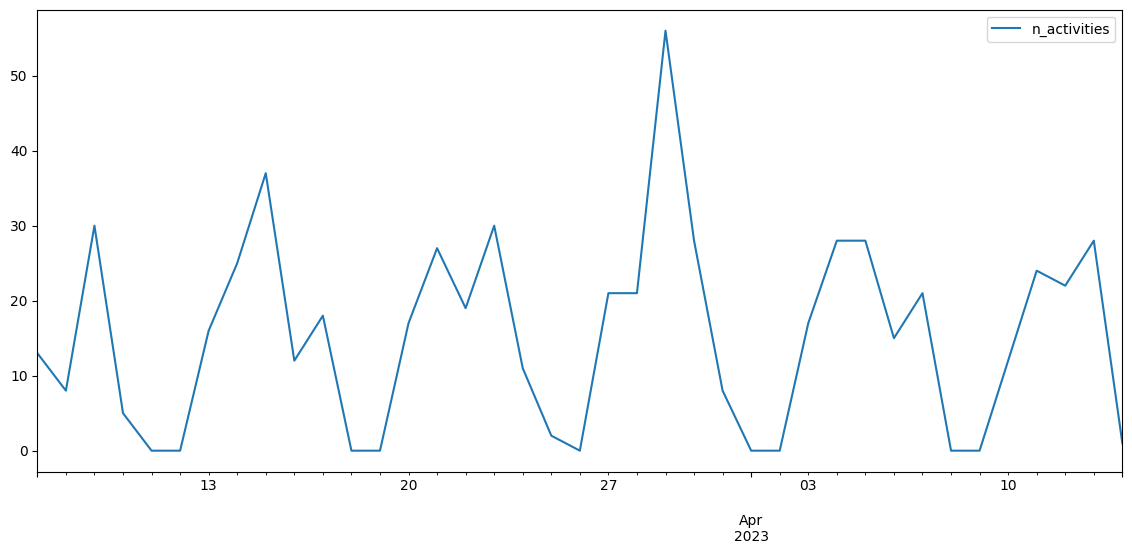

In [5]:
random_name = data['contributor'].sample().values[0]
random_user = data[data['contributor'] == random_name].reset_index(drop=True)

result = (
    random_user
    .groupby([pd.Grouper(key='date', freq='D')])['activity']
    .count()
    .reset_index(name='n_activities')
    .set_index('date')
    .resample('D')
    .sum()
    .rename_axis(None)
)
result.plot(figsize=(14, 6))

## 1. Mean approach

Find the frequency based on the mean of time differences between activities

In [6]:
def mean_based_frequency(contributor):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]
    time_range = (train_data['date'].iloc[-1] - train_data['date'].iloc[0]).total_seconds()//len(train_data)
    print("Time range is :", time_range)
    frequency = map_frequency(time_range)
    return frequency

In [7]:
# Example usage:
print("Frequence is :", mean_based_frequency(random_user))

Time range is : 6114.0
Frequence is : 1H


## 2. Quantile approach

Find the frequency based on the median of time differences between activities

In [8]:
def quantile_based_frequency(contributor, quantile=0.5):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]
    train_data['time_diff'] = train_data['date'].diff().dt.total_seconds()
    time_range = train_data['time_diff'].quantile(quantile)
    print("Time range is :", time_range)
    frequency = map_frequency(time_range)
    return frequency

In [9]:
# Example usage:
print("Frequence is :", quantile_based_frequency(random_user, quantile=0.5))

Time range is : 1779.0
Frequence is : 20T


## 3. Smallest time approach

Find the frequency based on the smallest time to do a specified number of activities (= 100) by sliding over the data

In [10]:
def smallest_time_based_frequency(contributor, window_size=100):
    train_data = contributor.head(300)
    train_data = train_data[train_data['date'] >= train_data['date'].max() - pd.DateOffset(months=3)]

    smallest_time = None
    # iterate over contributor's data in a sliding window
    for i in range(len(train_data) - window_size + 1):
        window = train_data.iloc[i:i + window_size]
        time_span = window['date'].iloc[-1] - window['date'].iloc[0]

        # the smallest time span
        if smallest_time is None or time_span < smallest_time:
            smallest_time = time_span

    time_range = smallest_time.total_seconds()//window_size

    print("Time range is :", time_range)
    frequency = map_frequency(time_range)

    return frequency

In [11]:
# Example usage:
print("Frequence is :", smallest_time_based_frequency(random_user, window_size=100))

Time range is : 3485.0
Frequence is : 30T


# Data splitting

In [12]:
def split_activities(contributor, frequency):

    result = (
        contributor
        .groupby([pd.Grouper(key='date', freq=frequency)])['activity']
        .count()
        .reset_index(name='n_activities')
        .set_index('date')
        .resample(frequency)
        .sum()
        .rename_axis(None)
        .assign(
            cumsum_activities = lambda x: x['n_activities'].cumsum()
        )
    )

    train, test = (
        result[result['cumsum_activities'] <= 300]
        .apply(lambda x : x[x.index >= x.index.max() - pd.DateOffset(months=3)])
        .drop('cumsum_activities', axis=1),

        result[result['cumsum_activities'] > 300]
        .drop('cumsum_activities', axis=1)
    )

    return train, test

Time range is : 3485.0


<Axes: >

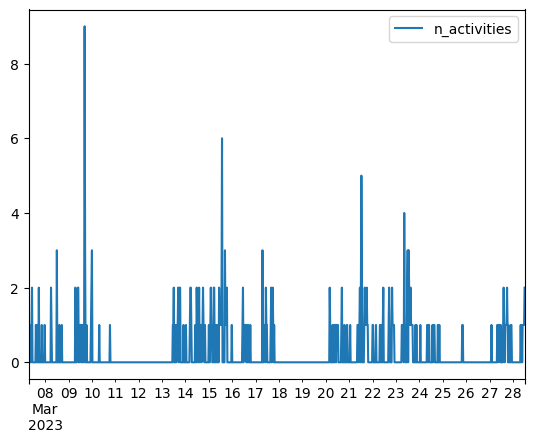

In [18]:
frequency = smallest_time_based_frequency(random_user, window_size=100)
train, test = split_activities(random_user, frequency)
train.plot()